# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
# from scipy.misc import imresize
# from PIL import Image
from skimage.io import imread
from skimage.transform import resize
import datetime
import os

In [2]:
# !pip install scipy==1.10.1
# !pip install PIL
# !pip install pillow
# !pip install scipy==1.1.0
# !pip uninstall scipy
# !pip show scipy #version ==1.9.0

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)
# tf.set_random_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
train_doc = np.random.permutation(open('./train.csv').readlines())
val_doc = np.random.permutation(open('./val.csv').readlines())
batch_size = 30 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
image_x_shape = 100
image_y_shape = 100

In [6]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = list(range(0, 30, 3)) #create a list of image numbers you want to use for a particular video
    x, y, z = len(img_idx), image_x_shape, image_y_shape
    while True:
        t = np.random.permutation(folder_list)
        total_folders = len(folder_list)
        num_batches = total_folders // batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, 
                                        #(y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    resizedImage = resize(image, (y, z),anti_aliasing=True)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] = resizedImage[:, :, 0] / 255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = resizedImage[:, :, 1] / 255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = resizedImage[:, :, 2] / 255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        missing_count = total_folders - (num_batches * batch_size)
        for folder in range(missing_count):
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
            for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                resizedImage = resize(image, (y, z),anti_aliasing=True)
                #crop the images and resize them. Note that the images are of 2 different shape 
                #and the conv3D will throw error if the inputs in a batch have different shapes

                batch_data[folder,idx,:,:,0] = resizedImage[:, :, 0] / 255 #normalise and feed in the image
                batch_data[folder,idx,:,:,1] = resizedImage[:, :, 1] / 255 #normalise and feed in the image
                batch_data[folder,idx,:,:,2] = resizedImage[:, :, 2] / 255 #normalise and feed in the image

            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
        yield batch_data, batch_labels
    # write the code for the remaining data points which are left after full batches


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [7]:
curr_dt_time = datetime.datetime.now()
train_path = './train'
val_path = './val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [8]:
from keras.models import Sequential, Model
from sklearn.metrics import roc_auc_score
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Conv2D, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers, regularizers
from keras.regularizers import l2
import keras

#write your model here

In [9]:
reduceLR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 2,
                             verbose = 1, mode = "auto", cooldown = 0)

In [10]:
import keras
class DecayLR(keras.callbacks.Callback):
    
    def __init__(self, base_lr=0.01, decay_epoch=1):
        super(DecayLR, self).__init__()
        self.base_lr = base_lr
        self.lr_history = []
        self.decay_epoch = decay_epoch
        
    def on_train_begin(self, logs={}):
        K.set_value(self.model.optimizer.lr, self.base_lr)
        
    def on_epoch_end(self, epoch, logs={}):
        new_lr = self.base_lr * (0.5 ** (epoch // self.decay_epoch))
        self.lr_history.append(K.get_value(self.model.optimizer.lr))
        K.set_value(self.model.optimizer.lr, new_lr)

In [11]:
class Convolution2DWithGRU():
    def __init__(self):
        return None
    
    def model(self, batch_size):
        cnn_model = Sequential()
        cnn_model.add(TimeDistributed(Conv2D(32, (1, 1), padding='same'), input_shape=(10, image_x_shape, image_y_shape, 3)))
        cnn_model.add(TimeDistributed(Activation('relu')))
        cnn_model.add(TimeDistributed(MaxPooling2D((3, 3), strides = (2,2))))
        cnn_model.add(TimeDistributed(BatchNormalization()))
        
        cnn_model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same')))
        cnn_model.add(TimeDistributed(Activation('relu')))
        cnn_model.add(TimeDistributed(MaxPooling2D((3, 3), strides = (2,2))))
        cnn_model.add(TimeDistributed(BatchNormalization()))
        
        cnn_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
        cnn_model.add(TimeDistributed(Activation('relu')))
        cnn_model.add(TimeDistributed(BatchNormalization()))
        cnn_model.add(Dropout(0.25))
        
        cnn_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
        cnn_model.add(TimeDistributed(Activation('relu')))
        
        
        cnn_model.add(TimeDistributed(MaxPooling2D((3, 3))))
        
        cnn_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same')))
        cnn_model.add(TimeDistributed(Activation('relu')))
        
        cnn_model.add(Dropout(0.25))
        
        cnn_model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
        cnn_model.add(TimeDistributed(Activation('relu')))

        cnn_model.add(Dropout(0.50))
        
        cnn_model.add(TimeDistributed(Conv2D(256, (5, 5), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
        cnn_model.add(TimeDistributed(Activation('relu')))

        
        cnn_model.add(TimeDistributed(Flatten()))
#         cnn_model.add(Dense(20))
        
        cnn_model.add(Dense(16))
        cnn_model.add(Dropout(.50))
        cnn_model.add(GRU(64, return_sequences=False))
#         cnn_model.add(Dense(32))
        cnn_model.add(Dense(5, activation='softmax'))
        return cnn_model

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [12]:
obj = Convolution2DWithGRU()
model = obj.model(batch_size)
optimiser = optimizers.Adam() #write your optimizer

model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 10, 100, 100, 32)  128      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 10, 100, 100, 32)  0        
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 10, 49, 49, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 10, 49, 49, 32)   128       
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 10, 49, 49, 32)   9

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [13]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [14]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = DecayLR(base_lr=0.1) # write the REducelronplateau code here
# callbacks_list = [checkpoint, LR]
# roc_callback = RocCallback()
callbacks_list = [checkpoint,reduceLR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [15]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [16]:
#_generator
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./train ; batch size = 30
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 4.7223 - categorical_accuracy: 0.1623Source path =  ./val ; batch size = 30

Epoch 1: saving model to model_init_2023-03-0411_30_32.668325\model-00001-4.72228-0.16232-3.61635-0.20000.h5
23/23 [==============================] - 105s 4s/step - loss: 4.7223 - categorical_accuracy: 0.1623 - val_loss: 3.6163 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 3.0367 - categorical_accuracy: 0.2130
Epoch 2: saving model to model_init_2023-03-0411_30_32.668325\model-00002-3.03675-0.21304-2.56176-0.19167.h5
23/23 [==============================] - 97s 4s/step - loss: 3.0367 - categorical_accuracy: 0.2130 - val_loss: 2.5618 - val_categorical_accuracy: 0.1917 - lr: 0.0010
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 2.1812 - categorical_accuracy: 0.3377
Epoch 3: saving model to model_init_2023-03-0411_30

23/23 [==============================] - 56s 2s/step - loss: 0.3903 - categorical_accuracy: 0.9203 - val_loss: 1.2226 - val_categorical_accuracy: 0.5750 - lr: 1.0000e-06
Epoch 22/30
23/23 [==============================] - ETA: 0s - loss: 0.3965 - categorical_accuracy: 0.9174
Epoch 22: saving model to model_init_2023-03-0411_30_32.668325\model-00022-0.39649-0.91739-0.97992-0.65833.h5
23/23 [==============================] - 56s 3s/step - loss: 0.3965 - categorical_accuracy: 0.9174 - val_loss: 0.9799 - val_categorical_accuracy: 0.6583 - lr: 1.0000e-06
Epoch 23/30
23/23 [==============================] - ETA: 0s - loss: 0.4053 - categorical_accuracy: 0.9116
Epoch 23: saving model to model_init_2023-03-0411_30_32.668325\model-00023-0.40530-0.91159-0.83067-0.73333.h5
23/23 [==============================] - 57s 3s/step - loss: 0.4053 - categorical_accuracy: 0.9116 - val_loss: 0.8307 - val_categorical_accuracy: 0.7333 - lr: 1.0000e-06
Epoch 24/30
23/23 [==============================] - ETA

In [18]:
print(model.history)

In [19]:
import matplotlib.pyplot as plt

class PlotMetrics():
    
    def draw(self, history):
        # ===> loss summary
        
        f, (ax1, ax2) = plt.subplots(1, 2, sharey=False)
        f.set_figheight(5)
        f.set_figwidth(15)
        
        ax1.plot(history.history['val_categorical_accuracy'])
        ax1.plot(history.history['categorical_accuracy'])
        ax1.title.set_text('model accuracy')
        ax1.set_ylabel('accuracy')
        ax1.set_xlabel('epoch')
        ax1.legend(['train', 'test'], loc='upper left')
        
        ax2.plot(history.history['val_loss'])
        ax2.plot(history.history['loss'])
        ax2.title.set_text('Loss function')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('epoch')
        ax2.legend(['train', 'test'], loc='upper left')
        plt.show()
        
        

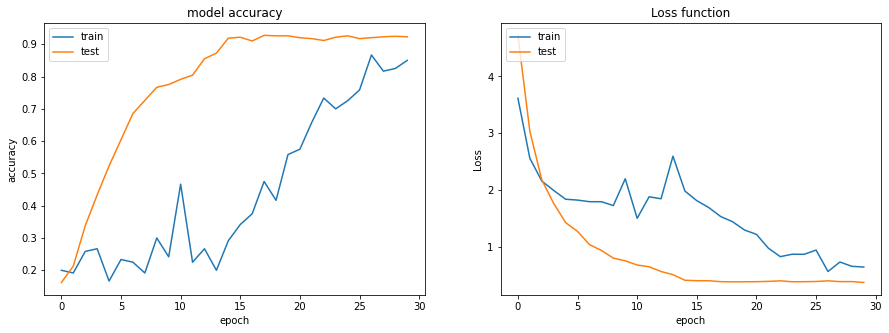

In [25]:
obj= PlotMetrics()
obj.draw(model.history)

## CONV3D Model:

In [40]:
class convolution3D():
    def __init__(self):
        return None
    
    def model2(self, batch_size):
        model = Sequential()
      
        model.add(Conv3D(8, kernel_size=(3, 3, 3),activation='relu', padding="same",input_shape=(10, 100, 100, 3)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(BatchNormalization())
        
        
        model.add(Conv3D(32, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        model.add(MaxPooling3D(pool_size=(2, 2, 1), data_format="channels_first"))
                               #strides=None, dim_ordering='th'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        
        model.add(MaxPooling3D(pool_size=(2, 2, 1),data_format="channels_first"))
                               #strides=None, dim_ordering='th'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2),data_format="channels_first"))
                               #strides=None, dim_ordering='th'))
        model.add(BatchNormalization())
        
       
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(256,activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(128,activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(64,activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(5, activation='softmax'))
        return model

In [42]:
obj = convolution3D()
conv3d_model = obj.model2(batch_size)
conv3d_optimiser = optimizers.Adam() #write your optimizer

conv3d_model.compile(optimizer=conv3d_optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (conv3d_model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_30 (Conv3D)          (None, 10, 100, 100, 8)   656       
                                                                 
 max_pooling3d_24 (MaxPoolin  (None, 5, 50, 50, 8)     0         
 g3D)                                                            
                                                                 
 batch_normalization_27 (Bat  (None, 5, 50, 50, 8)     32        
 chNormalization)                                                
                                                                 
 conv3d_31 (Conv3D)          (None, 5, 50, 50, 16)     3472      
                                                                 
 max_pooling3d_25 (MaxPoolin  (None, 2, 25, 25, 16)    0         
 g3D)                                                            
                                                      

In [43]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model_3d-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = DecayLR(base_lr=0.1) # write the REducelronplateau code here
# callbacks_list = [checkpoint, LR]
# roc_callback = RocCallback()
callbacks_list = [reduceLR,checkpoint]

In [44]:
conv3d_model_history = conv3d_model.fit_generator(train_generator,
                                           steps_per_epoch=steps_per_epoch,
                                           epochs=num_epochs,
                                           verbose=1,
                                           callbacks=callbacks_list,
                                           validation_data=val_generator,
                                           validation_steps=validation_steps,
                                           class_weight=None,
                                           workers=1,
                                           initial_epoch=0)

C:\Users\kanik\AppData\Local\Temp\ipykernel_28140\1917064895.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  conv3d_model_history = conv3d_model.fit_generator(train_generator,


Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 3.3017 - categorical_accuracy: 0.2304
Epoch 1: saving model to model_init_2023-03-0411_30_32.668325\model_3d-00001-3.30169-0.23043-2.62987-0.20833.h5
23/23 [==============================] - 43s 2s/step - loss: 3.3017 - categorical_accuracy: 0.2304 - val_loss: 2.6299 - val_categorical_accuracy: 0.2083 - lr: 0.0010
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 2.5994 - categorical_accuracy: 0.2725
Epoch 2: saving model to model_init_2023-03-0411_30_32.668325\model_3d-00002-2.59937-0.27246-2.50973-0.19167.h5
23/23 [==============================] - 41s 2s/step - loss: 2.5994 - categorical_accuracy: 0.2725 - val_loss: 2.5097 - val_categorical_accuracy: 0.1917 - lr: 0.0010
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 2.3604 - categorical_accuracy: 0.3232
Epoch 3: saving model to model_init_2023-03-0411_30_32.668325\model_3d-00003-2.36036-0.32319-2.49363-0.26667.h5
23/23 [=======

23/23 [==============================] - 42s 2s/step - loss: 1.9614 - categorical_accuracy: 0.4681 - val_loss: 1.9826 - val_categorical_accuracy: 0.4333 - lr: 1.0000e-07
Epoch 22/30
23/23 [==============================] - ETA: 0s - loss: 1.9621 - categorical_accuracy: 0.5058
Epoch 22: saving model to model_init_2023-03-0411_30_32.668325\model_3d-00022-1.96206-0.50580-2.03618-0.40833.h5
23/23 [==============================] - 41s 2s/step - loss: 1.9621 - categorical_accuracy: 0.5058 - val_loss: 2.0362 - val_categorical_accuracy: 0.4083 - lr: 1.0000e-07
Epoch 23/30
23/23 [==============================] - ETA: 0s - loss: 1.9434 - categorical_accuracy: 0.4826
Epoch 23: saving model to model_init_2023-03-0411_30_32.668325\model_3d-00023-1.94336-0.48261-1.97913-0.44167.h5
23/23 [==============================] - 43s 2s/step - loss: 1.9434 - categorical_accuracy: 0.4826 - val_loss: 1.9791 - val_categorical_accuracy: 0.4417 - lr: 1.0000e-07
Epoch 24/30
23/23 [==============================]

{'loss': [3.3016929626464844, 2.599372386932373, 2.3603601455688477, 2.3024063110351562, 2.1626906394958496, 2.057417869567871, 2.007255792617798, 1.9768595695495605, 1.9689637422561646, 1.96016526222229, 1.9061943292617798, 1.9080368280410767, 1.9612828493118286, 1.9756096601486206, 1.9323266744613647, 1.9658050537109375, 1.9235855340957642, 1.9825050830841064, 1.9466007947921753, 1.9393892288208008, 1.9614026546478271, 1.9620583057403564, 1.9433597326278687, 1.9832627773284912, 1.932439923286438, 1.9500699043273926, 1.9489296674728394, 1.9548099040985107, 2.018533706665039, 1.9771863222122192], 'categorical_accuracy': [0.23043477535247803, 0.27246376872062683, 0.3231883943080902, 0.3637681305408478, 0.3913043439388275, 0.4318840503692627, 0.4594202935695648, 0.469565212726593, 0.46666666865348816, 0.49275362491607666, 0.4797101318836212, 0.47101449966430664, 0.46666666865348816, 0.48695650696754456, 0.5028985738754272, 0.4797101318836212, 0.5043478012084961, 0.4942029118537903, 0.475

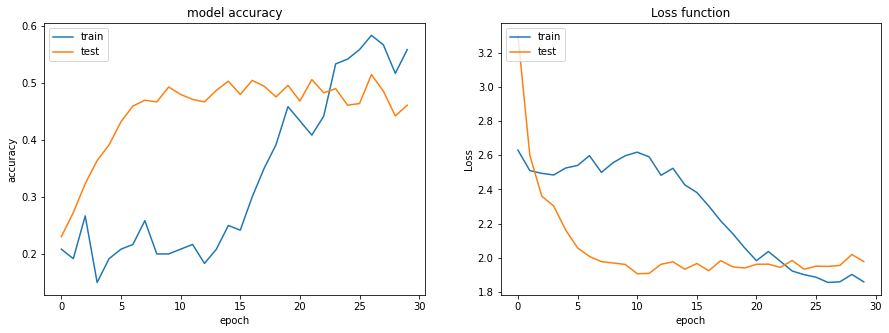

In [45]:
print(conv3d_model_history.history)
obj= PlotMetrics()
obj.draw(conv3d_model_history)